<a href="https://colab.research.google.com/github/krysttian7/Detecion-de-enfermedades-del-cacao-con-rasberry-pi/blob/main/Cacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
12#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

12




# Entrene un modelo de detección de objetos personalizado con TensorFlow Lite Model Maker

En este cuaderno de colaboración, aprenderá a usar [TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/guide/model_maker) para entrenar un modelo de detección de objetos personalizado para detectar las enfermedades del cacao con Moniliasis, Phytophthora y cacao sano y cómo poner el modelo en una Raspberry Pi.

La biblioteca de Model Maker usa *aprendizaje de transferencia* para simplificar el proceso de entrenamiento de un modelo de TensorFlow Lite usando un conjunto de datos personalizado. Volver a entrenar un modelo de TensorFlow Lite con su propio conjunto de datos personalizado reduce la cantidad de datos de entrenamiento necesarios y acortará el tiempo de entrenamiento.


## Preparación

### Instale los paquetes necesarios
Comience por instalar los paquetes necesarios, incluido el paquete Model Maker del [repositorio de GitHub](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) y la biblioteca pycocotools que usará para evaluación.

In [ ]:
!pip install -q tflite-model-maker
!pip install -q tflite-support
!sudo apt -y install libportaudio2
!pip install -q opencv-python-headless==4.1.2.30

     |████████████████████████████████| 642 kB 8.2 MB/s 
     |████████████████████████████████| 237 kB 70.0 MB/s 
     |████████████████████████████████| 3.4 MB 60.7 MB/s 
     |████████████████████████████████| 10.9 MB 56.7 MB/s 
     |████████████████████████████████| 120 kB 68.7 MB/s 
     |████████████████████████████████| 1.2 MB 57.8 MB/s 
     |████████████████████████████████| 42.5 MB 1.6 MB/s 
     |████████████████████████████████| 77 kB 6.8 MB/s 
     |████████████████████████████████| 6.4 MB 55.1 MB/s 
     |████████████████████████████████| 596 kB 68.4 MB/s 
     |████████████████████████████████| 840 kB 60.4 MB/s 
     |████████████████████████████████| 87 kB 7.8 MB/s 
     |████████████████████████████████| 1.1 MB 54.2 MB/s 
     |████████████████████████████████| 25.3 MB 1.4 MB/s 
     |████████████████████████████████| 99 kB 11.1 MB/s 
     |████████████████████████████████| 47.8 MB 1.2 MB/s 
     |████████████████████████████████| 352 kB 72.6 MB/s 
     |█████████████

Importe los paquetes necesarios.

In [ ]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat, QuantizationConfig
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

from tflite_support import metadata

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

### Preparar el conjunto de datos

Este conjunto de datos contiene 300 imágenes de entrenamiento, 100 de Moniliasis, 100 de Phytophthora y 100 de cacao sano y de validacion 60 imagenes, 20 de Moniliasis, 20 de Phytophthora y 20 de cacao sano. Esta es una imagen de ejemplo del conjunto de datos.
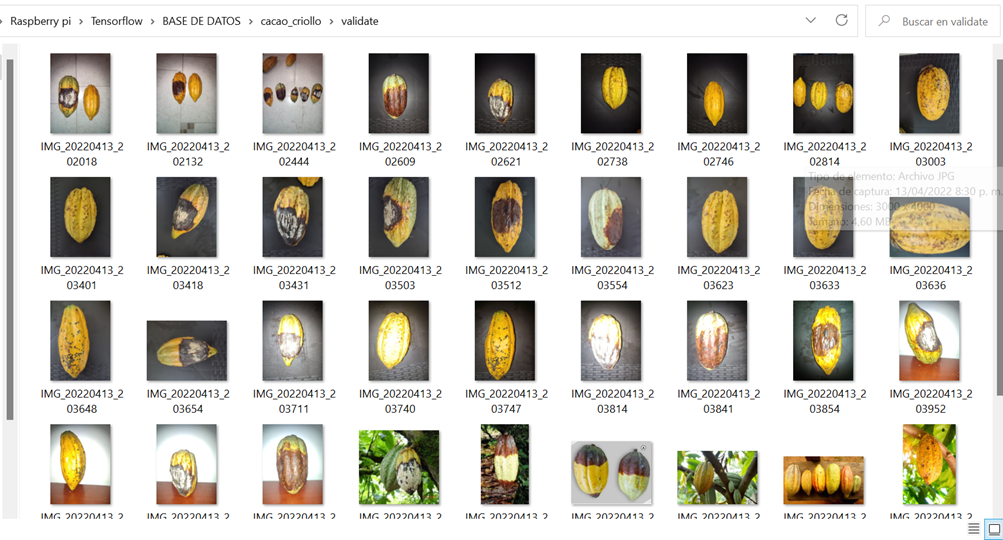


Comenzamos con la descarga del conjunto de datos.

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/fotos_entrenamiento1.zip" -d "/content/"

Archive:  /content/drive/MyDrive/Colab Notebooks/fotos_entrenamiento1.zip
   creating: /content/fotos_entrenamiento1/train/
  inflating: /content/fotos_entrenamiento1/train/IMG_20220413_201952.jpg  
  inflating: /content/fotos_entrenamiento1/train/IMG_20220413_201952.xml  
  inflating: /content/fotos_entrenamiento1/train/IMG_20220413_202008.jpg  
  inflating: /content/fotos_entrenamiento1/train/IMG_20220413_202008.xml  
  inflating: /content/fotos_entrenamiento1/train/IMG_20220413_202018.jpg  
  inflating: /content/fotos_entrenamiento1/train/IMG_20220413_202018.xml  
  inflating: /content/fotos_entrenamiento1/train/IMG_20220413_202047.jpg  
  inflating: /content/fotos_entrenamiento1/train/IMG_20220413_202047.xml  
  inflating: /content/fotos_entrenamiento1/train/IMG_20220413_202102.jpg  
  inflating: /content/fotos_entrenamiento1/train/IMG_20220413_202102.xml  
  inflating: /content/fotos_entrenamiento1/train/IMG_20220413_202124.jpg  
  inflating: /content/fotos_entrenamiento1/train/IM

## Entrena el modelo de detección de objetos

### Paso 1: Cargue el conjunto de datos

* Las imágenes en `train_data` se utilizan para entrenar el modelo de detección de objetos personalizado.
* Las imágenes en `val_data` se usan para verificar si el modelo puede generalizar bien a nuevas imágenes que no ha visto antes.

In [ ]:
train_data = object_detector.DataLoader.from_pascal_voc(
    'fotos_entrenamiento1/train',
    'fotos_entrenamiento1/train',
    ['MONILIASIS', 'PHYTOPHTHORA', 'CACAO SANO']
)

val_data = object_detector.DataLoader.from_pascal_voc(
    'fotos_entrenamiento1/validate',
    'fotos_entrenamiento1/validate',
    ['MONILIASIS', 'PHYTOPHTHORA', 'CACAO SANO']
)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


### Paso 2: Seleccione una arquitectura modelo

EfficientDet-Lite[0-4] es una familia de modelos de detección de objetos aptos para dispositivos móviles/IoT derivados de la arquitectura [EfficientDet](https://arxiv.org/abs/1911.09070).

Este es el rendimiento de cada modelo EfficientDet-Lite en comparación con los demás.

| Modelo de arquitectura | Tamaño (MB)* | Latencia (ms)** | Precisión media*** |
|--------------------------|-----------|---------------| ----------------------|
| EfficientDet-Lite0 | 4.4 | 146 | 25,69% |
| EfficientDet-Lite1 | 5.8 | 259 | 30,55% |
| EfficientDet-Lite2 | 7.2 | 396 | 33,97% |
| EfficientDet-Lite3 | 11.4 | 716 | 37,70% |
| EfficientDet-Lite4 | 19.9 | 1886 | 41,96% |

<i> * Tamaño de los modelos cuantificados enteros. <br/>
** Latencia medida en Raspberry Pi 4 usando 4 subprocesos en la CPU. <br/>
*** La precisión promedio es el mAP (precisión promedio promedio) en el conjunto de datos de validación de COCO 2017.
</i>

En este cuaderno, usamos EfficientDet-Lite2 para entrenar nuestro modelo. Puede elegir otras arquitecturas de modelos dependiendo de si la velocidad o la precisión son más importantes para usted.

In [ ]:
spec = model_spec.get('efficientdet_lite2')

### Paso 3: entrenar el modelo de TensorFlow con los datos de entrenamiento.

* Establezca `epochs = 30`, lo que significa que pasará por el conjunto de datos de entrenamiento 30 veces. Puede observar la precisión de la validación durante el entrenamiento y detenerse cuando vea que la pérdida de validación (`val_loss`) deja de disminuir para evitar el sobreajuste.
* Establezca `batch_size = 4` aquí para que vea que se necesitan 75 pasos para recorrer las 300 imágenes en el conjunto de datos de entrenamiento.
* Configure `train_whole_model=True` para ajustar todo el modelo en lugar de solo entrenar la capa principal para mejorar la precisión. La contrapartida es que puede llevar más tiempo entrenar el modelo.

In [ ]:
model = object_detector.create(train_data, model_spec=spec, batch_size=10, train_whole_model=True, epochs=30, validation_data=val_data)

Epoch 1/30
30/30 [==============================] - 231s 6s/step - det_loss: 1.7004 - cls_loss: 1.1352 - box_loss: 0.0113 - reg_l2_loss: 0.0761 - loss: 1.7764 - learning_rate: 0.0102 - gradient_norm: 1.4518 - val_det_loss: 1.4189 - val_cls_loss: 0.9810 - val_box_loss: 0.0088 - val_reg_l2_loss: 0.0761 - val_loss: 1.4949
Epoch 2/30
30/30 [==============================] - 160s 6s/step - det_loss: 1.2535 - cls_loss: 0.8395 - box_loss: 0.0083 - reg_l2_loss: 0.0761 - loss: 1.3296 - learning_rate: 0.0124 - gradient_norm: 2.7929 - val_det_loss: 1.2260 - val_cls_loss: 0.8023 - val_box_loss: 0.0085 - val_reg_l2_loss: 0.0761 - val_loss: 1.3021
Epoch 3/30
30/30 [==============================] - 146s 5s/step - det_loss: 1.0014 - cls_loss: 0.6463 - box_loss: 0.0071 - reg_l2_loss: 0.0761 - loss: 1.0775 - learning_rate: 0.0123 - gradient_norm: 3.2802 - val_det_loss: 0.8878 - val_cls_loss: 0.5623 - val_box_loss: 0.0065 - val_reg_l2_loss: 0.0762 - val_loss: 0.9640
Epoch 4/30
30/30 [===================

### Paso 4. Evaluar el modelo con los datos de validación.

Después de entrenar el modelo de detección de objetos con las imágenes del conjunto de datos de entrenamiento, usamos las 40 imágenes del conjunto de datos de validación para evaluar el rendimiento del modelo con datos nuevos que nunca antes había visto.

Como el tamaño de lote predeterminado es 300, se necesitará 1 paso para pasar por las 60 imágenes en el conjunto de datos de validación.

Las métricas de evaluación son las mismas que [COCO](https://cocodataset.org/#detection-eval).

In [ ]:
model.evaluate(val_data)

1/1 [==============================] - 26s 26s/step



{'AP': 0.37272698,
 'AP50': 0.74730116,
 'AP75': 0.35908163,
 'AP_/CACAO SANO': 0.5393573,
 'AP_/MONILIASIS': 0.16764417,
 'AP_/PHYTOPHTHORA': 0.4111794,
 'APl': 0.3532952,
 'APm': 0.7344434,
 'APs': -1.0,
 'ARl': 0.5339855,
 'ARm': 0.8,
 'ARmax1': 0.4226477,
 'ARmax10': 0.52814937,
 'ARmax100': 0.5459086,
 'ARs': -1.0}

### Paso 5: Exportar como modelo de TensorFlow Lite.

Exporte el modelo de detección de objetos entrenado al formato TensorFlow Lite especificando a qué carpeta desea exportar el modelo cuantificado. La técnica de cuantificación posterior al entrenamiento predeterminada es [cuantificación entera completa] (https://www.tensorflow.org/lite/performance/post_training_integer_quant). Esto permite que el modelo TensorFlow Lite sea más pequeño, se ejecute más rápido en la CPU Raspberry Pi y también sea compatible con Google Coral EdgeTPU.

In [ ]:
model.export(export_dir='.', tflite_filename='cacaof.tflite')

### Paso 6: Evaluar el modelo TensorFlow Lite.

Varios factores pueden afectar la precisión del modelo al exportar a TFLite:
* [Cuantificación](https://www.tensorflow.org/lite/performance/model_optimization) ayuda a reducir el tamaño del modelo 4 veces a expensas de una disminución de la precisión.
* El modelo TensorFlow original usa [supresión no máxima (NMS)] por clase (https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) para el posprocesamiento, mientras que el modelo TFLite usa NMS global que es mucho más rápido pero menos preciso.
Keras genera un máximo de 100 detecciones, mientras que tflite genera un máximo de 25 detecciones.

Por lo tanto, deberá evaluar el modelo TFLite exportado y comparar su precisión con el modelo TensorFlow original.

In [ ]:
model.evaluate_tflite('cacaof.tflite', val_data)

NameError: ignored

# Descargue el modelo TFLite a su computadora local.
de archivos de importación de google.colab
archivos.download('cacao.tflite')

## Probar el modelo de detección de figuras de cacao

Después de entrenar el modelo, probémoslo con una imagen que el modelo no haya visto antes para tener una idea de qué tan bueno es el modelo.

In [ ]:
#@title Cargue el modelo TFLite entrenado y defina algunas funciones de visualización

#@markdown Este código proviene de la detección de objetos TFLite [muestra de Raspberry Pi] (https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi).

import platform
from typing import List, NamedTuple
import json

import cv2

Interpreter = tf.lite.Interpreter
load_delegate = tf.lite.experimental.load_delegate

# pylint: enable=g-import-not-at-top


class ObjectDetectorOptions(NamedTuple):
  """A config to initialize an object detector."""

  enable_edgetpu: bool = False
  """Enable the model to run on EdgeTPU."""

  label_allow_list: List[str] = None
  """The optional allow list of labels."""

  label_deny_list: List[str] = None
  """The optional deny list of labels."""

  max_results: int = -1
  """The maximum number of top-scored detection results to return."""

  num_threads: int = 1
  """The number of CPU threads to be used."""

  score_threshold: float = 0.0
  """The score threshold of detection results to return."""


class Rect(NamedTuple):
  """A rectangle in 2D space."""
  left: float
  top: float
  right: float
  bottom: float


class Category(NamedTuple):
  """A result of a classification task."""
  label: str
  score: float
  index: int


class Detection(NamedTuple):
  """A detected object as the result of an ObjectDetector."""
  bounding_box: Rect
  categories: List[Category]


def edgetpu_lib_name():
  """Returns the library name of EdgeTPU in the current platform."""
  return {
      'Darwin': 'libedgetpu.1.dylib',
      'Linux': 'libedgetpu.so.1',
      'Windows': 'edgetpu.dll',
  }.get(platform.system(), None)


class ObjectDetector:
  """A wrapper class for a TFLite object detection model."""

  _OUTPUT_LOCATION_NAME = 'location'
  _OUTPUT_CATEGORY_NAME = 'category'
  _OUTPUT_SCORE_NAME = 'score'
  _OUTPUT_NUMBER_NAME = 'number of detections'

  def __init__(
      self,
      model_path: str,
      options: ObjectDetectorOptions = ObjectDetectorOptions()
  ) -> None:
    """Initialize a TFLite object detection model.
    Args:
        model_path: Path to the TFLite model.
        options: The config to initialize an object detector. (Optional)
    Raises:
        ValueError: If the TFLite model is invalid.
        OSError: If the current OS isn't supported by EdgeTPU.
    """

    # Load metadata from model.
    displayer = metadata.MetadataDisplayer.with_model_file(model_path)

    # Save model metadata for preprocessing later.
    model_metadata = json.loads(displayer.get_metadata_json())
    process_units = model_metadata['subgraph_metadata'][0]['input_tensor_metadata'][0]['process_units']
    mean = 0.0
    std = 1.0
    for option in process_units:
      if option['options_type'] == 'NormalizationOptions':
        mean = option['options']['mean'][0]
        std = option['options']['std'][0]
    self._mean = mean
    self._std = std

    # Load label list from metadata.
    file_name = displayer.get_packed_associated_file_list()[0]
    label_map_file = displayer.get_associated_file_buffer(file_name).decode()
    label_list = list(filter(lambda x: len(x) > 0, label_map_file.splitlines()))
    self._label_list = label_list

    # Initialize TFLite model.
    if options.enable_edgetpu:
      if edgetpu_lib_name() is None:
        raise OSError("The current OS isn't supported by Coral EdgeTPU.")
      interpreter = Interpreter(
          model_path=model_path,
          experimental_delegates=[load_delegate(edgetpu_lib_name())],
          num_threads=options.num_threads)
    else:
      interpreter = Interpreter(
          model_path=model_path, num_threads=options.num_threads)

    interpreter.allocate_tensors()
    input_detail = interpreter.get_input_details()[0]

    # From TensorFlow 2.6, the order of the outputs become undefined.
    # Therefore we need to sort the tensor indices of TFLite outputs and to know
    # exactly the meaning of each output tensor. For example, if
    # output indices are [601, 599, 598, 600], tensor names and indices aligned
    # are:
    #   - location: 598
    #   - category: 599
    #   - score: 600
    #   - detection_count: 601
    # because of the op's ports of TFLITE_DETECTION_POST_PROCESS
    # (https://github.com/tensorflow/tensorflow/blob/a4fe268ea084e7d323133ed7b986e0ae259a2bc7/tensorflow/lite/kernels/detection_postprocess.cc#L47-L50).
    sorted_output_indices = sorted(
        [output['index'] for output in interpreter.get_output_details()])
    self._output_indices = {
        self._OUTPUT_LOCATION_NAME: sorted_output_indices[0],
        self._OUTPUT_CATEGORY_NAME: sorted_output_indices[1],
        self._OUTPUT_SCORE_NAME: sorted_output_indices[2],
        self._OUTPUT_NUMBER_NAME: sorted_output_indices[3],
    }

    self._input_size = input_detail['shape'][2], input_detail['shape'][1]
    self._is_quantized_input = input_detail['dtype'] == np.uint8
    self._interpreter = interpreter
    self._options = options

  def detect(self, input_image: np.ndarray) -> List[Detection]:
    """Run detection on an input image.
    Args:
        input_image: A [height, width, 3] RGB image. Note that height and width
          can be anything since the image will be immediately resized according
          to the needs of the model within this function.
    Returns:
        A Person instance.
    """
    image_height, image_width, _ = input_image.shape

    input_tensor = self._preprocess(input_image)

    self._set_input_tensor(input_tensor)
    self._interpreter.invoke()

    # Get all output details
    boxes = self._get_output_tensor(self._OUTPUT_LOCATION_NAME)
    classes = self._get_output_tensor(self._OUTPUT_CATEGORY_NAME)
    scores = self._get_output_tensor(self._OUTPUT_SCORE_NAME)
    count = int(self._get_output_tensor(self._OUTPUT_NUMBER_NAME))

    return self._postprocess(boxes, classes, scores, count, image_width,
                             image_height)

  def _preprocess(self, input_image: np.ndarray) -> np.ndarray:
    """Preprocess the input image as required by the TFLite model."""

    # Resize the input
    input_tensor = cv2.resize(input_image, self._input_size)

    # Normalize the input if it's a float model (aka. not quantized)
    if not self._is_quantized_input:
      input_tensor = (np.float32(input_tensor) - self._mean) / self._std

    # Add batch dimension
    input_tensor = np.expand_dims(input_tensor, axis=0)

    return input_tensor

  def _set_input_tensor(self, image):
    """Sets the input tensor."""
    tensor_index = self._interpreter.get_input_details()[0]['index']
    input_tensor = self._interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

  def _get_output_tensor(self, name):
    """Returns the output tensor at the given index."""
    output_index = self._output_indices[name]
    tensor = np.squeeze(self._interpreter.get_tensor(output_index))
    return tensor

  def _postprocess(self, boxes: np.ndarray, classes: np.ndarray,
                   scores: np.ndarray, count: int, image_width: int,
                   image_height: int) -> List[Detection]:
    """Post-process the output of TFLite model into a list of Detection objects.
    Args:
        boxes: Bounding boxes of detected objects from the TFLite model.
        classes: Class index of the detected objects from the TFLite model.
        scores: Confidence scores of the detected objects from the TFLite model.
        count: Number of detected objects from the TFLite model.
        image_width: Width of the input image.
        image_height: Height of the input image.
    Returns:
        A list of Detection objects detected by the TFLite model.
    """
    results = []

    # Parse the model output into a list of Detection entities.
    for i in range(count):
      if scores[i] >= self._options.score_threshold:
        y_min, x_min, y_max, x_max = boxes[i]
        bounding_box = Rect(
            top=int(y_min * image_height),
            left=int(x_min * image_width),
            bottom=int(y_max * image_height),
            right=int(x_max * image_width))
        class_id = int(classes[i])
        category = Category(
            score=scores[i],
            label=self._label_list[class_id],  # 0 is reserved for background
            index=class_id)
        result = Detection(bounding_box=bounding_box, categories=[category])
        results.append(result)

    # Sort detection results by score ascending
    sorted_results = sorted(
        results,
        key=lambda detection: detection.categories[0].score,
        reverse=True)

    # Filter out detections in deny list
    filtered_results = sorted_results
    if self._options.label_deny_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label not in self.
              _options.label_deny_list, filtered_results))

    # Keep only detections in allow list
    if self._options.label_allow_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label in self._options.
              label_allow_list, filtered_results))

    # Only return maximum of max_results detection.
    if self._options.max_results > 0:
      result_count = min(len(filtered_results), self._options.max_results)
      filtered_results = filtered_results[:result_count]

    return filtered_results


_MARGIN = 10  # pixels
_ROW_SIZE = 10  # pixels
_FONT_SIZE = 1
_FONT_THICKNESS = 1
_TEXT_COLOR = (0, 0, 255)  # red


def visualize(
    image: np.ndarray,
    detections: List[Detection],
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detections: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detections:
    # Draw bounding_box
    start_point = detection.bounding_box.left, detection.bounding_box.top
    end_point = detection.bounding_box.right, detection.bounding_box.bottom
    cv2.rectangle(image, start_point, end_point, _TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    class_name = category.label
    probability = round(category.score, 2)
    result_text = class_name + ' (' + str(probability) + ')'
    text_location = (_MARGIN + detection.bounding_box.left,
                     _MARGIN + _ROW_SIZE + detection.bounding_box.top)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                _FONT_SIZE, _TEXT_COLOR, _FONT_THICKNESS)

  return image

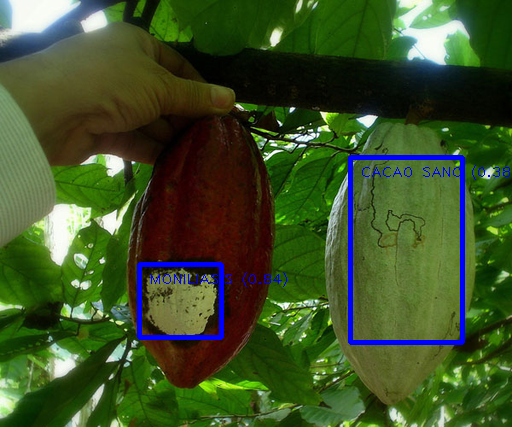

In [ ]:
#@title Ejecutar la detección de objetos y mostrar los resultados de la detección

from PIL import Image

INPUT_IMAGE_URL = "http://www.2000agro.com.mx/wp-content/uploads/moniliasis-paquetes.jpg" #@param {type:"string"}
DETECTION_THRESHOLD =  0.3#@param {type:"number"}
TFLITE_MODEL_PATH = "cacaof.tflite" #@param {type:"string"}

TEMP_FILE = '/tmp/image.png'

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
image = Image.open(TEMP_FILE).convert('RGB')
image.thumbnail((512, 512), Image.ANTIALIAS)
image_np = np.asarray(image)

# Load the TFLite model
options = ObjectDetectorOptions(
      num_threads=4,
      score_threshold=DETECTION_THRESHOLD,
)
detector = ObjectDetector(model_path=TFLITE_MODEL_PATH, options=options)

# Run object detection estimation using the model.
detections = detector.detect(image_np)

# Draw keypoints and edges on input image
image_np = visualize(image_np, detections)

# Show the detection result
Image.fromarray(image_np)

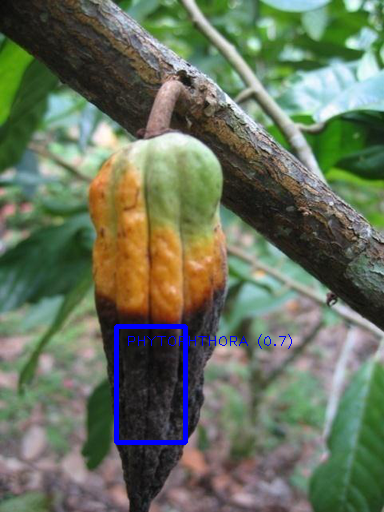

In [ ]:
#@title Ejecutar la detección de objetos y mostrar los resultados de la detección

from PIL import Image

INPUT_IMAGE_URL = "https://docplayer.es/docs-images/64/52020537/images/9-1.jpg" #@param {type:"string"}
DETECTION_THRESHOLD =  0.6#@param {type:"number"}
TFLITE_MODEL_PATH = "cacaof.tflite" #@param {type:"string"}

TEMP_FILE = '/tmp/image.png'

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
image = Image.open(TEMP_FILE).convert('RGB')
image.thumbnail((512, 512), Image.ANTIALIAS)
image_np = np.asarray(image)

# Load the TFLite model
options = ObjectDetectorOptions(
      num_threads=4,
      score_threshold=DETECTION_THRESHOLD,
)
detector = ObjectDetector(model_path=TFLITE_MODEL_PATH, options=options)

# Run object detection estimation using the model.
detections = detector.detect(image_np)

# Draw keypoints and edges on input image
image_np = visualize(image_np, detections)

# Show the detection result
Image.fromarray(image_np)